In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
from pathlib import Path
from datetime import datetime
from matplotlib import pyplot as plt
import datetime

In [2]:
from scipy.stats import shapiro
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import statsmodels
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import boxcox

In [3]:
%matplotlib inline

In [4]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#### Read in data

In [5]:
data_path = "D:\\Users\\Nicholas\\Projects\\repos\\spc_charts\\data\\raw\\"

In [6]:
data = pd.read_csv(Path(data_path) / 'nCov-2019 SG - Sheet1.csv')

In [7]:
data['Date'] = pd.to_datetime(data['Date'])

#### Plot

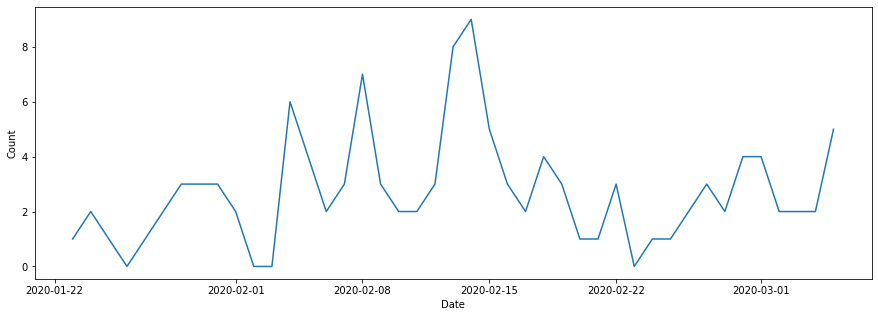

In [8]:
fig, ax = plt.subplots(figsize=(15,5))
sns.relplot(x='Date', y='Count', data=data, kind='line', ax=ax)
plt.close()

#### Get subset of data

In [9]:
data_filter = (data['Date'] >= '2020-02-15') & (data['Date'] < '2020-04')

In [10]:
in_control_filter = (data['Date'] >= '2020-02-15') & (data['Date'] < '2020-03-06')

In [11]:
cutoff = '2020-02-15'

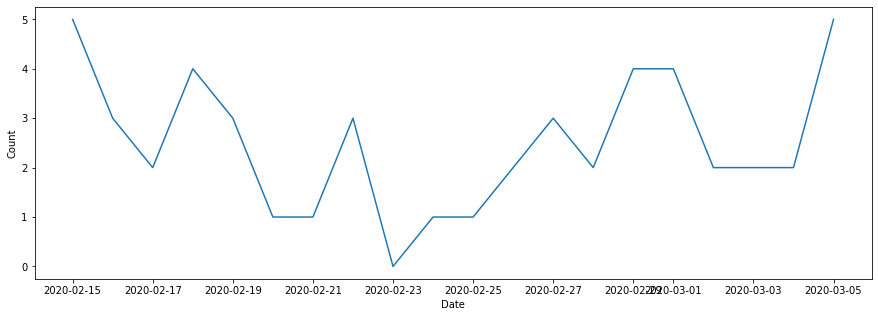

In [12]:
fig, ax = plt.subplots(figsize=(15,5))
sns.relplot(x='Date', y='Count', data=data[data_filter], kind='line', ax=ax)
plt.close()

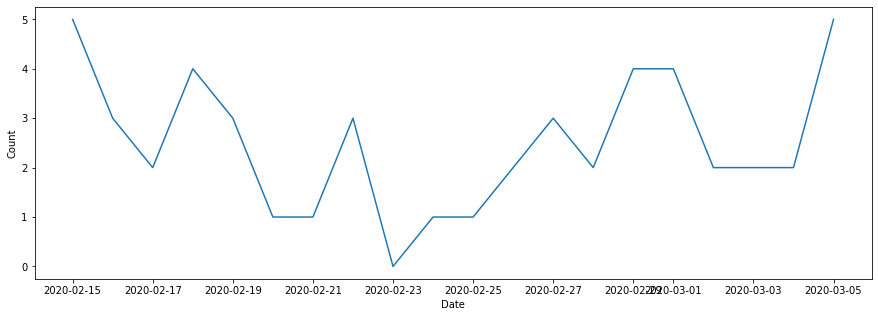

In [13]:
fig, ax = plt.subplots(figsize=(15,5))
sns.relplot(x='Date', y='Count', data=data[in_control_filter], kind='line', ax=ax)
plt.close()

#### Hypothesis test

#### Auto correlation

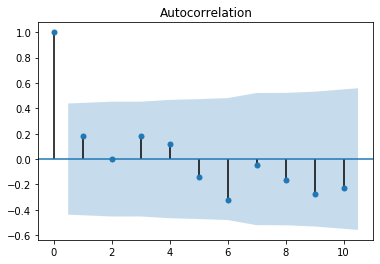

In [14]:
_ = plot_acf(data.loc[in_control_filter, 'Count'], lags=10)

In [15]:
acorr_ljungbox(data.loc[in_control_filter, 'Count'], lags=10)

(array([ 0.77073161,  0.77073161,  1.63213753,  2.03891255,  2.62948962,
         5.93534373,  6.01105874,  6.97526619, 10.04502514, 12.36715808]),
 array([0.37999082, 0.68020177, 0.652125  , 0.72860177, 0.75687974,
        0.43047182, 0.53845867, 0.53930361, 0.34685249, 0.26123512]))

#### Check if poisson distribution is appropriate

In [16]:
import scipy.stats as stats
import scipy as sp

In [17]:
sample_mean = data.loc[in_control_filter, 'Count'].mean()
sample_variance = data.loc[in_control_filter, 'Count'].var()

In [18]:
sample_mean

2.5

In [19]:
sample_variance

1.9473684210526316

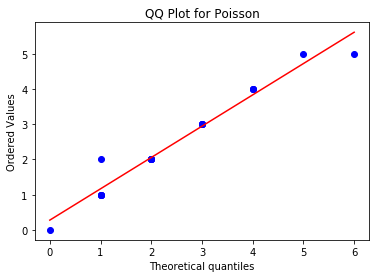

In [20]:
fig, ax = plt.subplots()
_ = stats.probplot(data.loc[in_control_filter, 'Count'], dist=stats.poisson, sparams=(sample_mean, ), plot=ax)
_ = plt.title('QQ Plot for Poisson')

#### Use Chisq goodness of fit

In [21]:
obs = data.loc[in_control_filter, 'Count']
obs_x = obs.sort_values().unique().tolist()

In [22]:
theoretical_freq = pd.Series(stats.poisson.pmf(obs_x, obs.mean()), index = obs_x)
obs_freq = obs.value_counts() / obs.value_counts().sum()

In [23]:
compare_df = pd.concat([theoretical_freq, obs_freq], axis=1)
compare_df.columns = ['theoretical_freq', 'obs_freq']

In [24]:
compare_df

,theoretical_freq,obs_freq
0,0.082085,0.05
1,0.205212,0.20
2,0.256516,0.30
3,0.213763,0.20
4,0.133602,0.15
5,0.066801,0.10


In [25]:
stats.chisquare(f_obs = compare_df.obs_freq, f_exp=compare_df.theoretical_freq)

Power_divergenceResult(statistic=0.039443315684262584, pvalue=0.9999837942806682)

#### Use Poisson Control Chart (C Chart)

In [26]:
def c_chart(arg, mu0):
    
    UCL = mu0 + 3 * np.sqrt(mu0)
    center = mu0
    LCL = mu0 - 3 * np.sqrt(mu0)
    
    # Counts cannot be negative
    if LCL < 0:
        LCL = 0
    
    ret_df = pd.DataFrame({
        'x':arg.tolist(),
        'UCL':UCL,
        'Center':center,
        'LCL':LCL
    })
    
    return ret_df
    

In [27]:
x_ind_df = c_chart(data.loc[in_control_filter, 'Count'], data.loc[in_control_filter, 'Count'].mean())

In [28]:
x_ind_df = pd.concat([data.loc[in_control_filter, 'Date'].reset_index(drop=True), x_ind_df], axis=1)

(array([737470., 737471., 737472., 737473., 737474., 737475., 737476.,
        737477., 737478., 737479., 737480., 737481., 737482., 737483.,
        737484., 737485., 737486., 737487., 737488., 737489.]),
 <a list of 20 Text xticklabel objects>)

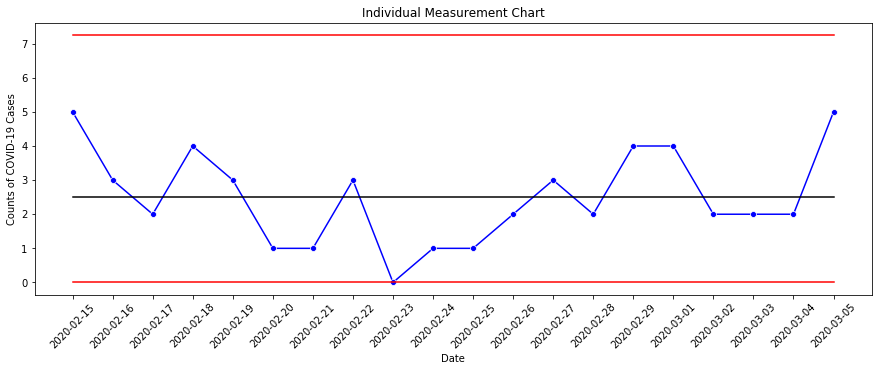

In [29]:
fig, ax = plt.subplots(figsize=(15,5))
sns.relplot(x='Date', y='x', data=x_ind_df, kind='line', ax=ax, color='blue', marker='o')
sns.lineplot(x='Date', y='UCL', data=x_ind_df, drawstyle='steps-pre', ax=ax, color='red')
sns.lineplot(x='Date', y='LCL', data=x_ind_df, drawstyle='steps-pre', ax=ax, color='red')
sns.relplot(x='Date', y='Center', data=x_ind_df, kind='line', ax=ax, color='black')
plt.close()
plt.close()
plt.title('Individual Measurement Chart')
plt.ylabel('Counts of COVID-19 Cases')
ax.set(xticks=x_ind_df.Date.values)
plt.xticks(rotation=45)